# **Medical Insurance Charges Prediction**

In [1]:
# Import Libraries & Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools for modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor


In [2]:
# Load the insurance dataset
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data Description
- **age**: Age of primary beneficiary
- **sex**: Gender of beneficiary
- **bmi**: Body mass index
- **children**: Number of children covered by insurance
- **smoker**: Smoking status
- **region**: Residential area in the US
- **charges**: Medical insurance cost (target variable)

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.describe() 


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## **Exploratory Data Analysis (EDA)**


##### **Distribution of numerical features**

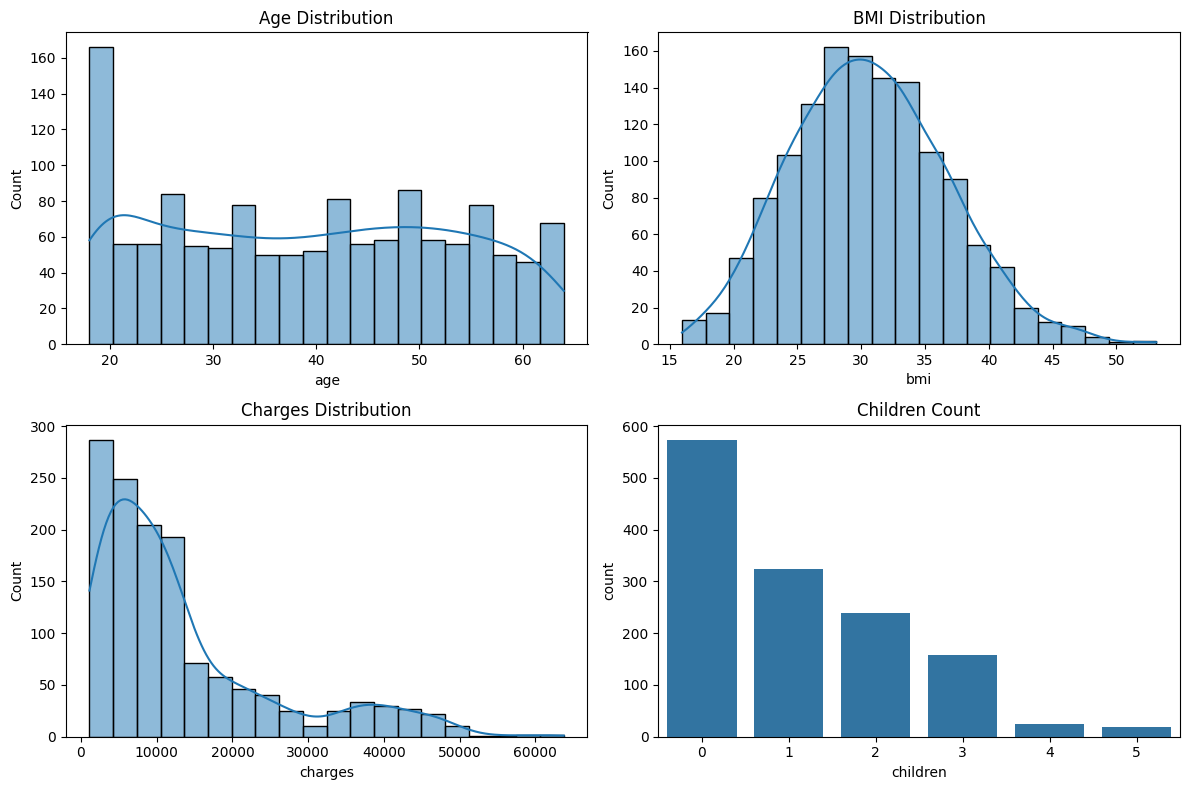

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['age'], bins=20, ax=axs[0,0], kde=True)
axs[0,0].set_title('Age Distribution')
sns.histplot(df['bmi'], bins=20, ax=axs[0,1], kde=True)
axs[0,1].set_title('BMI Distribution')
sns.histplot(df['charges'], bins=20, ax=axs[1,0], kde=True)
axs[1,0].set_title('Charges Distribution')
sns.countplot(x='children', data=df, ax=axs[1,1])
axs[1,1].set_title('Children Count')
plt.tight_layout()
plt.show()

##### **Distribution of categorical features**

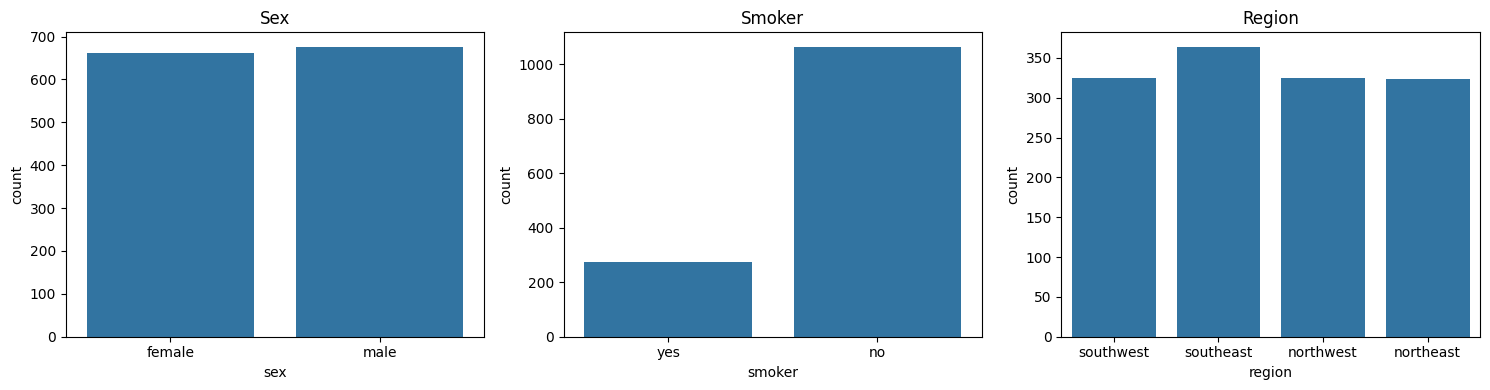

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.countplot(x='sex', data=df, ax=axs[0])
sns.countplot(x='smoker', data=df, ax=axs[1])
sns.countplot(x='region', data=df, ax=axs[2])
axs[0].set_title('Sex')
axs[1].set_title('Smoker')
axs[2].set_title('Region')
plt.tight_layout()
plt.show()

##### **Relationship between features and target**

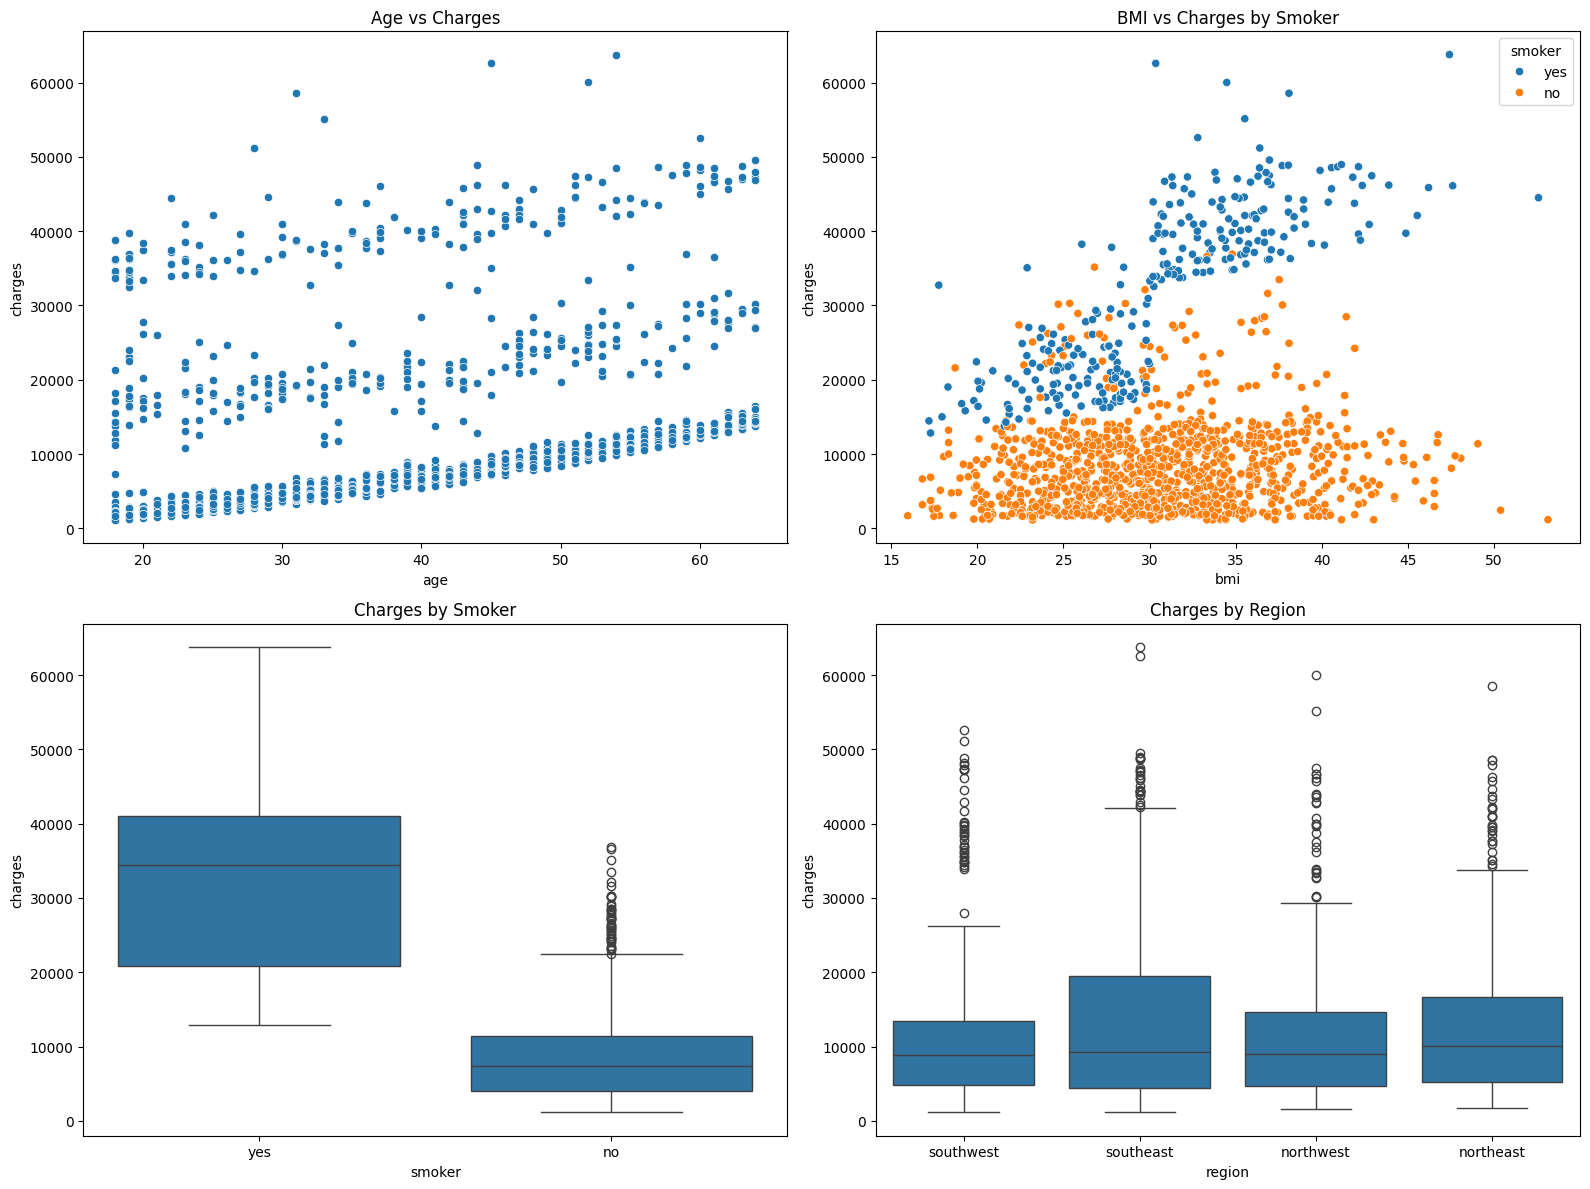

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 1. Age vs Charges
sns.scatterplot(x='age', y='charges', data=df, ax=axs[0, 0])
axs[0, 0].set_title('Age vs Charges')

# 2. BMI vs Charges by Smoker
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, ax=axs[0, 1])
axs[0, 1].set_title('BMI vs Charges by Smoker')

# 3. Charges by Smoker
sns.boxplot(x='smoker', y='charges', data=df, ax=axs[1, 0])
axs[1, 0].set_title('Charges by Smoker')

# 4. Charges by Region
sns.boxplot(x='region', y='charges', data=df, ax=axs[1, 1])
axs[1, 1].set_title('Charges by Region')

plt.tight_layout()
plt.show()

##### **Correlation Heatmap: Visualize relationships between all numerical features**

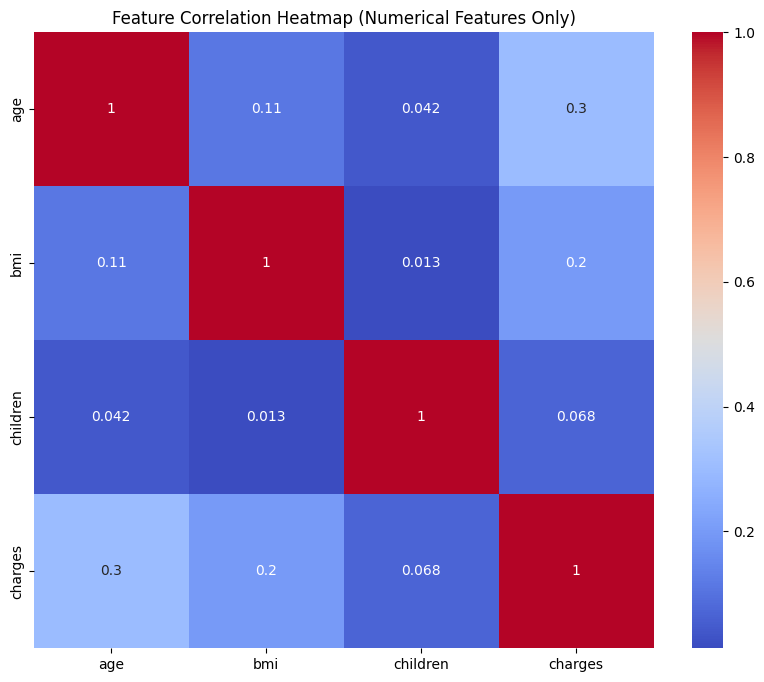

In [9]:
num_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap (Numerical Features Only)')
plt.show()

## Data Preprocessing & Feature Engineering
We will encode categorical variables, scale numerical features, and split the data.

In [10]:
# Data Preprocessing & Feature Engineering
# Separate features (X) and target (y)
X = df.drop('charges', axis=1)  
y = df['charges']              

In [11]:
# Identify column types
categorical_cols = ['sex', 'smoker', 'region']
numerical_cols = ['age', 'bmi', 'children']

In [12]:
# Build preprocessing pipeline
#    - Standardize numerical features
#    - One-hot encode categorical features (drop first to avoid multicollinearity)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
], remainder='passthrough')

In [13]:

#. Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (1070, 6)
Test set size: (268, 6)


## Model Selection & Fine Tuning
We will train and tune 5 models:
1. Linear Regression
2. Random Forest Regressor
3. XGBoost Regressor
4. LightGBM Regressor
5. CatBoost Regressor

In [14]:
# Linear Regression Model (with Regularization)
from sklearn.linear_model import Ridge

lr_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', Ridge(alpha=1.0, random_state=42))
])

In [15]:
# Reduced hyperparameter grid for Ridge
lr_params = {'model__alpha': [0.1, 1.0, 10.0]}  

lr_grid = GridSearchCV(
    lr_pipeline, lr_params, cv=3,  
    scoring='neg_root_mean_squared_error', n_jobs=-1
)

In [16]:
lr_grid.fit(X_train, y_train)
y_pred_lr = lr_grid.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)
print(f"Ridge Regression RMSE: {lr_rmse:.2f}, R2: {lr_r2:.2f}")
print('Best Ridge alpha:', lr_grid.best_params_['model__alpha'])

Ridge Regression RMSE: 5800.46, R2: 0.78
Best Ridge alpha: 1.0


In [17]:
# Random Forest Regressor 
rf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

In [18]:
# Reduced hyperparameter grid
rf_params = {
    'model__n_estimators': [100, 200,],
    'model__max_depth': [None, 10],
    'model__min_samples_split': [2, 5]

}

In [19]:
rf_grid = GridSearchCV(
    rf_pipeline, rf_params, cv=5,  
    scoring='neg_root_mean_squared_error', n_jobs=-1
)
rf_grid.fit(X_train, y_train)
y_pred_rf = rf_grid.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rf_rmse:.2f}, R2: {rf_r2:.2f}")
print('Best RF params:', rf_grid.best_params_)

Random Forest RMSE: 4499.91, R2: 0.87
Best RF params: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}


In [20]:
# XGBoost Regressor (with Improved Hyperparameter Tuning)
xgb_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', xgb.XGBRegressor(random_state=42, verbosity=0, n_jobs=-1))
])

In [21]:

# Reduced hyperparameter grid with regularization
xgb_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6],
    'model__learning_rate': [0.01, 0.1],
    'model__reg_alpha': [0, 0.1],
    'model__reg_lambda': [1, 2]
}

In [22]:

xgb_grid = GridSearchCV(
    xgb_pipeline, xgb_params, cv=3,  
    scoring='neg_root_mean_squared_error', n_jobs=-1
)
xgb_grid.fit(X_train, y_train)
y_pred_xgb = xgb_grid.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)
print(f"XGBoost RMSE: {xgb_rmse:.2f}, R2: {xgb_r2:.2f}")
print('Best XGBoost params:', xgb_grid.best_params_)

XGBoost RMSE: 4274.22, R2: 0.88
Best XGBoost params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__reg_alpha': 0.1, 'model__reg_lambda': 2}


In [23]:
# LightGBM Regressor (Faster Iteration, Good Result)
lgb_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', lgb.LGBMRegressor(random_state=42, n_jobs=-1))
])

In [24]:
# Smaller hyperparameter grid for speed, but still allows some tuning
lgb_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [6, 10],
    'model__learning_rate': [0.05, 0.1],
    'model__reg_alpha': [0, 0.1],
    'model__reg_lambda': [1, 2]
}

In [ ]:

lgb_grid = GridSearchCV(
    lgb_pipeline, lgb_params, cv=3,
    scoring='neg_root_mean_squared_error', n_jobs=-1
)
lgb_grid.fit(X_train, y_train)
y_pred_lgb = lgb_grid.predict(X_test)
lgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
lgb_r2 = r2_score(y_test, y_pred_lgb)
print(f"LightGBM RMSE: {lgb_rmse:.2f}, R2: {lgb_r2:.2f}")
print('Best LightGBM params:', lgb_grid.best_params_)

In [ ]:
# CatBoost Regressor
cat_features = [X.columns.get_loc(col) for col in categorical_cols]
cat_params = {
    'iterations': [100, 200],
    'depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3]
}

In [ ]:

cat_grid = GridSearchCV(
    CatBoostRegressor(verbose=0, random_state=42),
    cat_params, cv=3, 
    scoring='neg_root_mean_squared_error', n_jobs=-1
)
cat_grid.fit(X_train, y_train, cat_features=cat_features)
y_pred_cat = cat_grid.predict(X_test)
cat_rmse = np.sqrt(mean_squared_error(y_test, y_pred_cat))
cat_r2 = r2_score(y_test, y_pred_cat)
print(f"CatBoost RMSE: {cat_rmse:.2f}, R2: {cat_r2:.2f}")
print('Best CatBoost params:', cat_grid.best_params_)

CatBoost RMSE: 4279.78, R2: 0.88
Best CatBoost params: {'depth': 3, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


## Prediction & Evaluation
We will compare the performance of all models.

In [ ]:
# table for all models
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

models_simple = [
    ("Linear Regression", lr_grid.best_estimator_),
    ("Random Forest", rf_grid.best_estimator_),
    ("XGBoost", xgb_grid.best_estimator_),
    ("LightGBM", lgb_grid.best_estimator_),
    ("CatBoost", cat_grid.best_estimator_)
]

In [ ]:

rows = []
for name, model in models_simple:
    if name == "CatBoost":
        # CatBoost needs special handling for categorical features
        train_r2 = model.score(X_train, y_train)
        test_r2 = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        cv_scores = []
        for train_idx, val_idx in cv.split(X, y):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
            model.fit(X_tr, y_tr, cat_features=[X.columns.get_loc(col) for col in categorical_cols])
            preds = model.predict(X_val)
            cv_scores.append(r2_score(y_val, preds))
        cv_mean = np.mean(cv_scores)
    else:
        train_r2 = model.score(X_train, y_train)
        test_r2 = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
        cv_mean = np.mean(cv_scores)
    rows.append([name, f"{rmse:.2f}", f"{train_r2:.3f}", f"{test_r2:.3f}", f"{cv_mean:.3f}"])

predict = pd.DataFrame(rows, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

c:\Users\ROG Zephyrus G15\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ROG Zephyrus G15\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ROG Zephyrus G15\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,Model,RMSE,R2_Score(training),R2_Score(test),Cross-Validation
0,Linear Regression,5800.46,0.742,0.783,0.740
1,Random Forest,4499.91,0.945,0.870,0.840
2,XGBoost,4274.22,0.891,0.882,0.857
3,LightGBM,4367.52,0.900,0.877,0.849
4,CatBoost,4279.78,0.873,0.882,0.857


### Learning Curve: Model Performance vs. Training Set Size
A learning curve shows how the model's error changes as the training set size increases. It helps diagnose underfitting or overfitting.

c:\Users\ROG Zephyrus G15\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:70: FutureWarning: `fit_params` is deprecated and will be removed in version {version}. Pass parameters via `params` instead.
  warnings.warn(


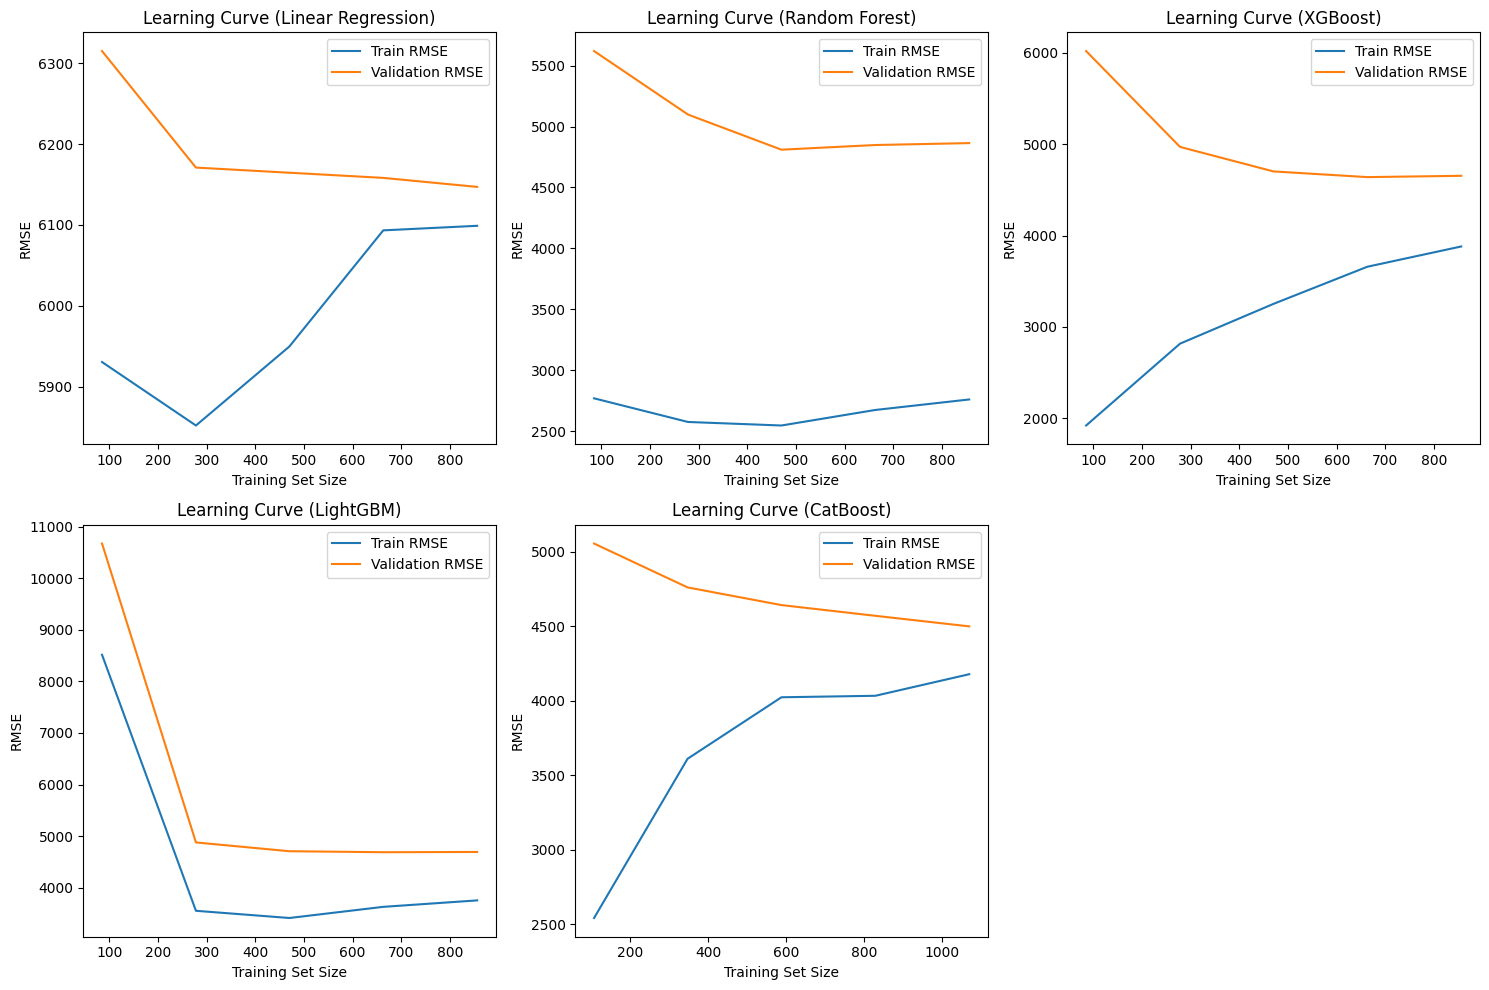

In [ ]:
# Learning Curves for All Models: Train vs Validation RMSE
from sklearn.model_selection import learning_curve

models_list = [
    ("Linear Regression", lr_pipeline, X_train, y_train, {}),
    ("Random Forest", rf_grid.best_estimator_, X_train, y_train, {}),
    ("XGBoost", xgb_grid.best_estimator_, X_train, y_train, {}),
    ("LightGBM", lgb_grid.best_estimator_, X_train, y_train, {}),
    ("CatBoost", cat_grid.best_estimator_, X_train, y_train, {'cat_features': [X.columns.get_loc(col) for col in categorical_cols]})
]

plt.figure(figsize=(15, 10))
for i, (name, model, Xtr, ytr, extra_args) in enumerate(models_list, 1):
    if name == "CatBoost":
        train_sizes, train_scores, test_scores = learning_curve(
            model,
            X,
            y,
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            fit_params=extra_args
        )
    else:
        train_sizes, train_scores, test_scores = learning_curve(
            model,
            X_train,
            y_train,
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
    plt.subplot(2, 3, i)
    plt.plot(train_sizes, -train_scores.mean(axis=1), label='Train RMSE')
    plt.plot(train_sizes, -test_scores.mean(axis=1), label='Validation RMSE')
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.title(f'Learning Curve ({name})')
    plt.legend()
plt.tight_layout()
plt.show()

### Compare Model Result

In [ ]:
# Compare model results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost'],
    'RMSE': [lr_rmse, rf_rmse, xgb_rmse, lgb_rmse, cat_rmse],
    'R2': [lr_r2, rf_r2, xgb_r2, lgb_r2, cat_r2]
})
results.sort_values('RMSE')

# Show sample predictions from the best model (lowest RMSE)
best_idx = results['RMSE'].idxmin()
best_model_name = results.loc[best_idx, 'Model']
print(f'Best Model: {best_model_name}')
if best_model_name == 'Linear Regression':
    sample_preds = y_pred_lr[:10]
elif best_model_name == 'Random Forest':
    sample_preds = y_pred_rf[:10]
elif best_model_name == 'XGBoost':
    sample_preds = y_pred_xgb[:10]
elif best_model_name == 'LightGBM':
    sample_preds = y_pred_lgb[:10]
else:
    sample_preds = y_pred_cat[:10]
print('Sample predictions:', sample_preds)

Best Model: XGBoost
Sample predictions: [10842.196   5892.4023 27525.312  10055.964  33866.39    5249.3013
  3622.0024 16182.751   5050.1943 11091.735 ]


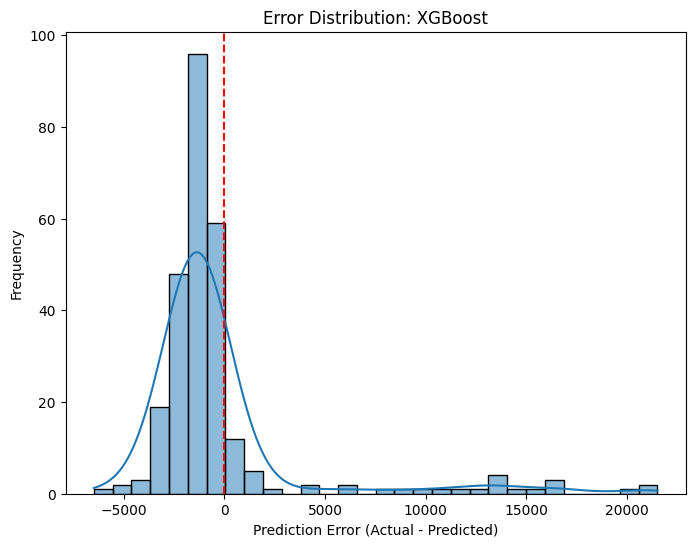

In [ ]:
# Error Distribution Plot for the Best Model
# Gather all model predictions in a list
all_model_preds = [y_pred_lr, y_pred_rf, y_pred_xgb, y_pred_lgb, y_pred_cat]
errors = y_test - all_model_preds[best_idx]
plt.figure(figsize=(8,6))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title(f'Error Distribution: {best_model_name}')
plt.axvline(0, color='red', linestyle='--')
plt.show()

### How to Interpret Underfitting & Overfitting Results
- **Good Fit**: Train and test RMSE are close. The model generalizes well.
- **Possible Overfitting**: Test RMSE is much higher than train RMSE. The model may be too complex or not regularized enough. Try reducing model complexity or using regularization.
- **Possible Underfitting**: Train RMSE is higher than test RMSE, or both are high. The model may be too simple. Try increasing model complexity or adding features.



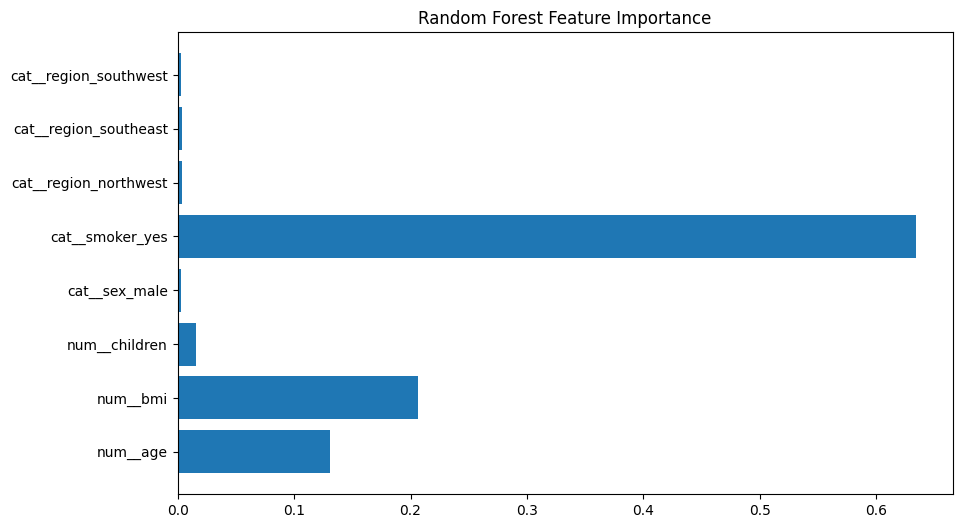

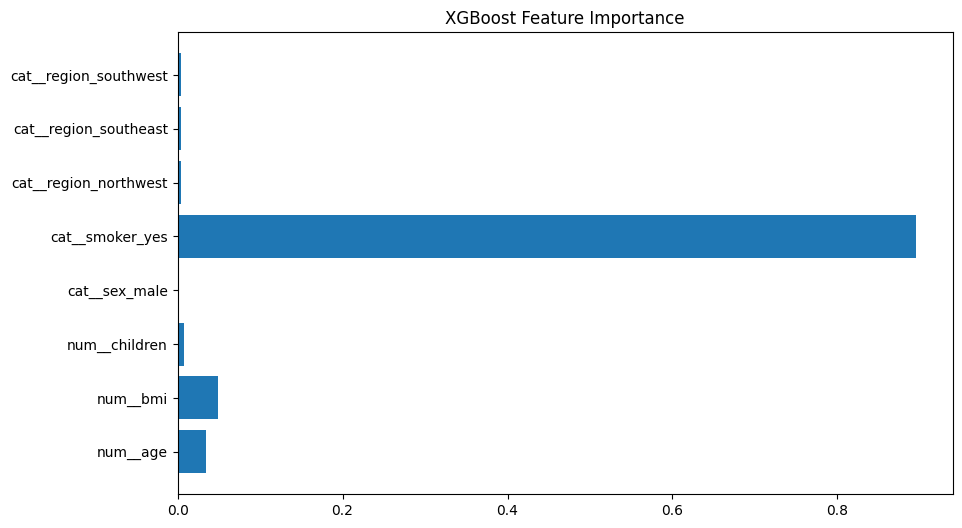

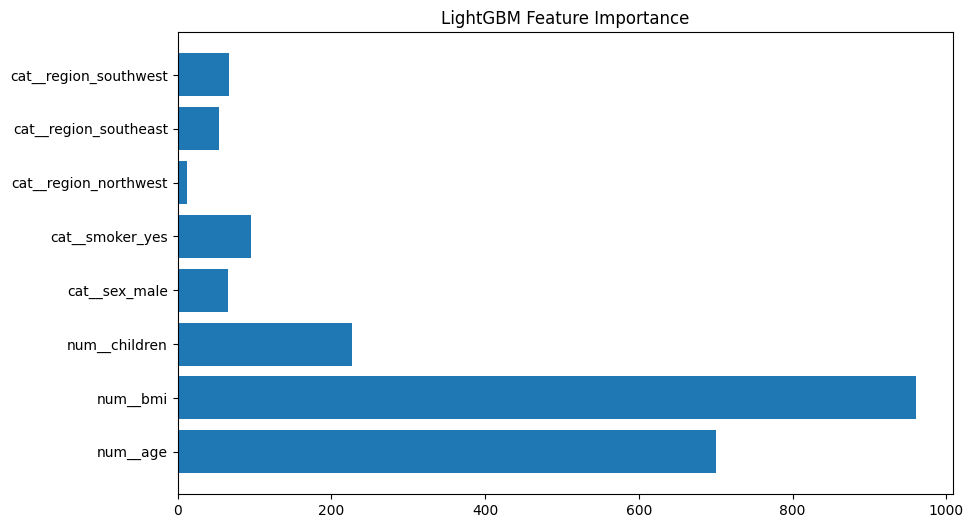

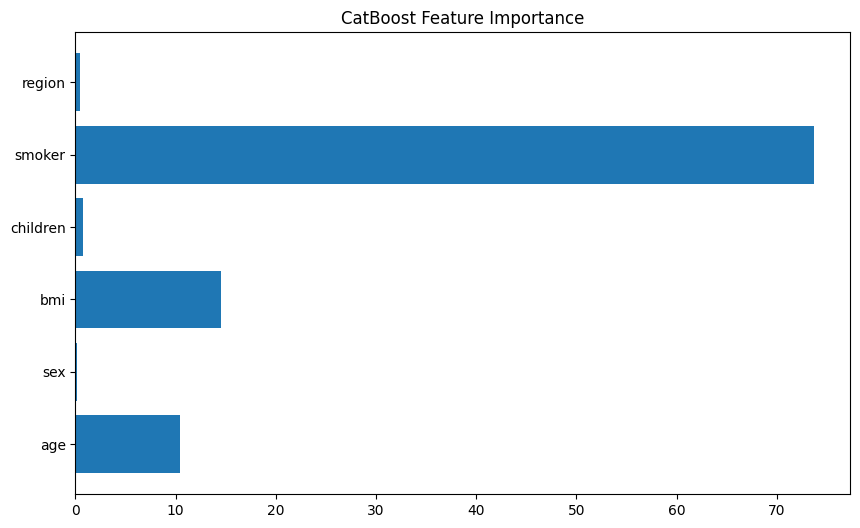

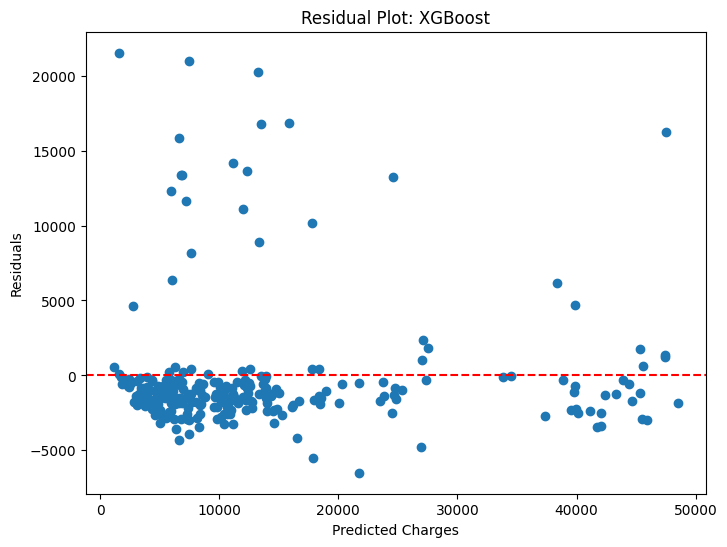

In [ ]:
# Feature Importance for Tree-Based Models
importances_rf = rf_grid.best_estimator_.named_steps['model'].feature_importances_
importances_xgb = xgb_grid.best_estimator_.named_steps['model'].feature_importances_
importances_lgb = lgb_grid.best_estimator_.named_steps['model'].feature_importances_
importances_cat = cat_grid.best_estimator_.feature_importances_
feature_names = rf_grid.best_estimator_.named_steps['pre'].get_feature_names_out()
plt.figure(figsize=(10,6))
plt.barh(feature_names, importances_rf)
plt.title('Random Forest Feature Importance')
plt.show()
plt.figure(figsize=(10,6))
plt.barh(feature_names, importances_xgb)
plt.title('XGBoost Feature Importance')
plt.show()
plt.figure(figsize=(10,6))
plt.barh(feature_names, importances_lgb)
plt.title('LightGBM Feature Importance')
plt.show()
# For CatBoost, use original feature names
cat_feature_names = X.columns
plt.figure(figsize=(10,6))
plt.barh(cat_feature_names, importances_cat)
plt.title('CatBoost Feature Importance')
plt.show()

# Residual Plot for Best Model
best_model_preds = [y_pred_lr, y_pred_rf, y_pred_xgb, y_pred_lgb, y_pred_cat]
residuals = y_test - best_model_preds[best_idx]
plt.figure(figsize=(8,6))
plt.scatter(best_model_preds[best_idx], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.title(f'Residual Plot: {best_model_name}')
plt.show()

In [ ]:
# Save the trained pipeline (preprocessor + model) for real-life prediction
import joblib
joblib.dump(rf_grid.best_estimator_, 'rf_tuned.pkl')

['rf_tuned.pkl']